# Project 4: Natural Language Processing (NLP)
## Task 4

### Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [1]:
# --- Setup & Imports ---
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter, defaultdict
import json
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.cuda.amp import GradScaler
from torch.nn.utils import clip_grad_norm_
from torch.cuda import is_available
from torch import cuda

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    get_scheduler, DataCollatorForTokenClassification
)
from transformers import AutoTokenizer

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, recall_score
)
from itertools import chain
from copy import deepcopy

from tqdm.auto import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 12 17:38:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
laboratory = 'Laboratory4'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/Task4-Chiara/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/Laboratory4/
Data path: /content/drive/MyDrive/Projects/Laboratory4/data/
Results path: /content/drive/MyDrive/Projects/Laboratory4/results/Task4-Chiara/


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(111)

In [9]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

## Helper Functions

In [10]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving (Colab/Google Drive only)
# ============================================================================
SAVE_PLOTS = 1
# ============================================================================

import os
import matplotlib.pyplot as plt

os.makedirs(results_path, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Save the current matplotlib figure for use in the report.

    Args:
        filename: Name of the file (e.g., 'class_distribution.png')
        dpi: Resolution (default 300 for high quality)
        bbox_inches: Bounding box setting (default 'tight' to remove whitespace)
    """
    if not SAVE_PLOTS:
        return  # Skip saving if flag is disabled or filename missing

    filepath = os.path.join(results_path, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")


In [ ]:
def compute_metrics(full_predictions, full_labels):
    """Compute token-level classification metrics"""
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))

    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)

    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

In [ ]:
def postprocess(predictions, labels):
    """Convert predictions and labels to original label format"""
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

In [ ]:
def tokenize_and_align_labels_unixcoder(samples, tokenizer):
    """Tokenize and align labels for UniXcoder"""
    split_sentences = [s.split(" ") for s in samples["session"]]


    # Truncate words longer than 30 characters
    split_sentences = [
        [word[:30] for word in sentence]
        for sentence in split_sentences
    ]

    tokenized = tokenizer(
        split_sentences,
        truncation=True,
        is_split_into_words=True
    )

    all_labels = samples["label_id"]
    aligned_all = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized.word_ids(i)

        aligned = []
        prev_word = None

        for wid in word_ids:
            if wid is None:
                aligned.append(-100)
            else:
                if wid != prev_word:
                    aligned.append(labels[wid])
                    prev_word = wid
                else:
                    aligned.append(-100)
        aligned_all.append(aligned)

    tokenized["labels"] = aligned_all
    return tokenized


In [ ]:
def training_loop(model, optimizer, lr_scheduler, train_loader, val_loader, device, num_epochs):
    scaler = torch.amp.GradScaler()
    best_val_loss = np.inf
    best_weights = deepcopy(model.state_dict())

    # Calculate steps dynamically based on the passed loader
    num_training_steps = num_epochs * len(train_loader)
    progress_bar = tqdm(range(num_training_steps))

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            # Move batch to device
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            optimizer.zero_grad(set_to_none=True)

            # Automatic Mixed Precision
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            train_loss += loss.item()
            progress_bar.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        val_loss = 0
        predictions_list, labels_list = [], []

        for batch in val_loader:
            batch = {key: value.to(device, non_blocking=True) for key, value in batch.items()}
            with torch.no_grad():
                with torch.amp.autocast(device_type='cuda'):  # ← FIXED HERE
                    outputs = model(**batch)

            val_loss += outputs.loss.item()
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]

            true_predictions, true_labels = postprocess(predictions, labels)
            predictions_list += true_predictions
            labels_list += true_labels

        # Compute validation metrics
        val_metrics = compute_metrics(predictions_list, labels_list)
        val_accuracy = val_metrics["token_accuracy"]

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Optional: Print progress
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss <= best_val_loss:
            best_epoch = epoch
            best_val_loss = avg_val_loss
            best_weights = deepcopy(model.state_dict())

    # Load the best weights found during this specific training run
    model.load_state_dict(best_weights)
    return model, best_epoch, best_val_loss, train_losses, val_losses

In [ ]:
def evaluate_model(model, dataloader, device):
    """Evaluate model on a dataset"""
    model.eval()
    full_predictions, full_labels = [], []
    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions += true_predictions
        full_labels += true_labels

    test_metrics = compute_metrics(full_predictions, full_labels)
    return full_predictions, full_labels, test_metrics

## Re-Train Best Model from Task 3

### Dataset Loading and preparation

In [ ]:
# Load training and test data
train_df = pd.read_json(f"{data_path}train.json")
test_df = pd.read_json(f"{data_path}test.json")

print(f"Training dataset: {train_df.shape[0]} sessions")
print(f"Test dataset: {test_df.shape[0]} sessions")

Training dataset: 251 sessions
Test dataset: 108 sessions


In [ ]:
# Split training data into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"Split training: {train_df.shape[0]} train, {val_df.shape[0]} validation")

Split training: 200 train, 51 validation


In [ ]:
# Create label mappings
unique_labels = list(train_df.label.explode().unique())
print(f"Unique labels: {unique_labels}")

id2label = {id: label for id, label in enumerate(unique_labels)}
label2id = {label: id for id, label in enumerate(unique_labels)}

print(f"Label mappings: {label2id}")

Unique labels: ['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']
Label mappings: {'Execution': 0, 'Discovery': 1, 'Not Malicious Yet': 2, 'Persistence': 3, 'Other': 4, 'Defense Evasion': 5, 'Impact': 6}


In [ ]:
# Create Hugging Face datasets
full_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

In [ ]:
# Convert labels to IDs
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample

encoded_dataset = full_ds.map(convert_labels_to_ids)
print(f"Encoded dataset: {encoded_dataset}")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Encoded dataset: DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})


### Tokenization

In [ ]:
# Create tokenizer and model checkpoint
unixcoder_model_checkpoint = "microsoft/unixcoder-base"
unixcoder_tokenizer = AutoTokenizer.from_pretrained(
    unixcoder_model_checkpoint,
    add_prefix_space=True,
    use_fast=True,
    model_max_length=512
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
# Tokenize datasets
original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    lambda x: tokenize_and_align_labels_unixcoder(x, unixcoder_tokenizer),
    batched=True,
    remove_columns=original_columns,
)

print(f"Tokenized dataset: {tokenized_datasets}")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})


In [ ]:
# Create data collator
data_collator = DataCollatorForTokenClassification(
    tokenizer=unixcoder_tokenizer,
    return_tensors="pt"
)

In [ ]:
# Create DataLoaders
tokenized_datasets.set_format("torch")

BATCH_SIZE = 16
NUM_WORKERS = 2

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

eval_dataloader = DataLoader(
    tokenized_datasets["valid"],
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders created successfully")

DataLoaders created successfully


### Train the model

In [ ]:
print("\n" + "="*80)
print("SECTION 3: TRAIN BEST MODEL FROM TASK 3")
print("UNIXCODER FULL FINE-TUNE WITH LR=1e-05")
print("="*80)

N_TRAIN_EPOCHS = 15
BEST_LR = 1e-5

print(f"\nTraining parameters:")
print(f"  - Model: UniXcoder (microsoft/unixcoder-base)")
print(f"  - Learning Rate: {BEST_LR}")
print(f"  - Epochs: {N_TRAIN_EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Device: {device}")


SECTION 3: TRAIN BEST MODEL FROM TASK 3
UNIXCODER FULL FINE-TUNE WITH LR=1e-05

Training parameters:
  - Model: UniXcoder (microsoft/unixcoder-base)
  - Learning Rate: 1e-05
  - Epochs: 15
  - Batch Size: 16
  - Device: cuda


In [ ]:
# Initialize model
best_model = AutoModelForTokenClassification.from_pretrained(
    unixcoder_model_checkpoint,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
).to(device)

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Setup optimizer and scheduler
optimizer = optim.AdamW(best_model.parameters(), lr=BEST_LR)

num_training_steps = N_TRAIN_EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
# Train
set_seed(111)
best_model, best_epoch, best_val_loss, train_losses, val_losses = training_loop(
    best_model, optimizer, lr_scheduler,
    train_dataloader, eval_dataloader, device, N_TRAIN_EPOCHS
)

print("\n" + "="*80)
print(f"Training complete! Best epoch: {best_epoch + 1}, Best val loss: {best_val_loss:.4f}")
print("="*80)

  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 1.5731 | Val Loss: 0.8877
Epoch 2/15 | Train Loss: 0.8969 | Val Loss: 0.6458
Epoch 3/15 | Train Loss: 0.6816 | Val Loss: 0.5797
Epoch 4/15 | Train Loss: 0.5113 | Val Loss: 0.4801
Epoch 5/15 | Train Loss: 0.4656 | Val Loss: 0.4646
Epoch 6/15 | Train Loss: 0.3302 | Val Loss: 0.4239
Epoch 7/15 | Train Loss: 0.2680 | Val Loss: 0.4265
Epoch 8/15 | Train Loss: 0.2217 | Val Loss: 0.3925
Epoch 9/15 | Train Loss: 0.1985 | Val Loss: 0.3993
Epoch 10/15 | Train Loss: 0.1812 | Val Loss: 0.4147
Epoch 11/15 | Train Loss: 0.1734 | Val Loss: 0.3902
Epoch 12/15 | Train Loss: 0.1465 | Val Loss: 0.3931
Epoch 13/15 | Train Loss: 0.1430 | Val Loss: 0.3900
Epoch 14/15 | Train Loss: 0.1255 | Val Loss: 0.3917
Epoch 15/15 | Train Loss: 0.1242 | Val Loss: 0.3994

Training complete! Best epoch: 13, Best val loss: 0.3900


In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_preds, test_labels, test_metrics = evaluate_model(best_model, test_dataloader, device)

print(f"\nTest Set Performance:")
print(f"  - Token Accuracy: {test_metrics['token_accuracy']:.4f}")
print(f"  - Macro F1-Score: {test_metrics['token_f1']:.4f}")
print(f"  - Macro Precision: {test_metrics['token_precision']:.4f}")
print(f"  - Macro Recall: {test_metrics['token_recall']:.4f}")


Evaluating on test set...

Test Set Performance:
  - Token Accuracy: 0.8889
  - Macro F1-Score: 0.6831
  - Macro Precision: 0.8354
  - Macro Recall: 0.6169


In [ ]:
# # Save best model for later use in inference
# model_save_path = os.path.join(results_path, "best_unixcoder_model_task3")
# os.makedirs(model_save_path, exist_ok=True)
# best_model.save_pretrained(model_save_path)
# unixcoder_tokenizer.save_pretrained(model_save_path)

# print(f"\nBest model saved to: {model_save_path}")

## Inference Datasets

In [ ]:
# Load cyberlab.csv
cyberlab_df = pd.read_csv(f"{data_path}cyberlab.csv")

print(f"Cyberlab dataset: {len(cyberlab_df)} sessions")
print(f"Columns: {list(cyberlab_df.columns)}")
print(f"Data types:\n{cyberlab_df.dtypes}")
print(f"\nFirst few rows:")
print(cyberlab_df.head(3))

# Convert timestamps_statements to datetime
cyberlab_df['timestamps_statements'] = pd.to_datetime(cyberlab_df['timestamps_statements'])
cyberlab_df['date'] = cyberlab_df['timestamps_statements'].dt.date

print(f"\nDate range: {cyberlab_df['date'].min()} to {cyberlab_df['date'].max()}")

Cyberlab dataset: 174262 sessions
Columns: ['session', 'timestamps_statements', 'country_name']
Data types:
session                  object
timestamps_statements    object
country_name             object
dtype: object

First few rows:
                                             session  \
0  enable ; system ; shell ; sh ; cat /proc/mount...   
1  enable ; system ; shell ; sh ; cat /proc/mount...   
2  enable ; system ; shell ; sh ; cat /proc/mount...   

              timestamps_statements country_name  
0  2019-09-01 00:00:10.493808+00:00       Israel  
1  2019-09-01 00:38:41.134935+00:00       Israel  
2  2019-09-01 00:39:26.263383+00:00       Israel  

Date range: 2019-09-01 to 2019-12-30


## Inference Functions

In [ ]:
def truncate_long_words(session, max_length=30):
    """Truncate words longer than max_length (matching Task 3 preprocessing)"""
    words = session.split()
    truncated = []
    for word in words:
        if len(word) > max_length:
            truncated.append(word[:max_length])
        else:
            truncated.append(word)
    return ' '.join(truncated)

## Batch Inference on Cyberlab Dataset

In [ ]:
import time
start_time = time.time()

commands_of_interest = ['cat', 'grep', 'echo', 'rm']

# Step 1: Preprocess all sessions
print("Step 1: Preprocessing sessions (vectorizing)...")
t1 = time.time()
cyberlab_df['session_clean'] = cyberlab_df['session'].apply(truncate_long_words)
cyberlab_df['words'] = cyberlab_df['session_clean'].str.split()
t1_elapsed = time.time() - t1
print(f"Done in {t1_elapsed:.1f}s")

# Step 2: Tokenize in MINI-BATCHES to avoid memory issues
print(f"Step 2: Tokenizing {len(cyberlab_df)} sessions in mini-batches...")
t2 = time.time()

MINI_BATCH_SIZE = 64
all_word_ids = []
all_predictions = []

total_batches = (len(cyberlab_df) + MINI_BATCH_SIZE - 1) // MINI_BATCH_SIZE

Step 1: Preprocessing sessions (vectorizing)...
Done in 5.0s
Step 2: Tokenizing 174262 sessions in mini-batches...


In [ ]:
for batch_idx in range(total_batches):
    batch_start = batch_idx * MINI_BATCH_SIZE
    batch_end = min(batch_start + MINI_BATCH_SIZE, len(cyberlab_df))

    # Get batch sessions
    batch_words = [cyberlab_df.iloc[i]['words'] for i in range(batch_start, batch_end)]

    try:
        # Tokenize batch WITHOUT return_tensors first (to keep word_ids method)
        tokenized = unixcoder_tokenizer(
            batch_words,
            truncation=True,
            is_split_into_words=True,
            padding=True
        )

        # Extract word_ids BEFORE converting to tensors
        batch_word_ids = [tokenized.word_ids(i) for i in range(len(batch_words))]

        # Now convert to tensors
        tokenized = {k: torch.tensor(v) for k, v in tokenized.items()}

        # Move to device
        tokenized = {k: v.to(device) for k, v in tokenized.items()}

        # Inference on batch
        best_model.eval()
        with torch.no_grad():
            outputs = best_model(**tokenized)
            logits = outputs.logits

        # Store predictions and word_ids
        preds = logits.argmax(dim=-1).cpu().numpy()

        for session_offset in range(len(batch_words)):
            all_word_ids.append(batch_word_ids[session_offset])
            all_predictions.append(preds[session_offset])

        # Clean up
        del tokenized, logits, preds, outputs
        torch.cuda.empty_cache()

        if (batch_idx + 1) % 100 == 0:
            elapsed = time.time() - t2
            rate = (batch_idx + 1) * MINI_BATCH_SIZE / elapsed
            remaining = (total_batches - batch_idx - 1) * MINI_BATCH_SIZE / rate
            print(f"  Batch {batch_idx + 1}/{total_batches} | {rate:.0f} sess/s | ETA: {remaining/60:.1f}min")

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"  WARNING: OOM at batch {batch_idx + 1}. Reducing batch size and retrying...")
            torch.cuda.empty_cache()
            # Retry with smaller batch
            MINI_BATCH_SIZE = max(16, MINI_BATCH_SIZE // 2)
            print(f"  New batch size: {MINI_BATCH_SIZE}")
            raise e
        else:
            raise

t2_elapsed = time.time() - t2
print(f"  Tokenization & inference done in {t2_elapsed:.1f}s ({len(cyberlab_df)/t2_elapsed:.0f} sessions/sec)")
print(f"  Mini-batch size used: {MINI_BATCH_SIZE}")

  Batch 100/2723 | 50 sess/s | ETA: 56.2min
  Batch 200/2723 | 50 sess/s | ETA: 54.3min
  Batch 300/2723 | 49 sess/s | ETA: 52.9min
  Batch 400/2723 | 50 sess/s | ETA: 49.9min
  Batch 500/2723 | 50 sess/s | ETA: 47.2min
  Batch 600/2723 | 51 sess/s | ETA: 44.7min
  Batch 700/2723 | 51 sess/s | ETA: 42.5min
  Batch 800/2723 | 51 sess/s | ETA: 40.3min
  Batch 900/2723 | 51 sess/s | ETA: 38.1min
  Batch 1000/2723 | 51 sess/s | ETA: 36.0min
  Batch 1100/2723 | 51 sess/s | ETA: 34.1min
  Batch 1200/2723 | 51 sess/s | ETA: 32.1min
  Batch 1300/2723 | 51 sess/s | ETA: 30.1min
  Batch 1400/2723 | 50 sess/s | ETA: 28.1min
  Batch 1500/2723 | 50 sess/s | ETA: 26.0min
  Batch 1600/2723 | 50 sess/s | ETA: 23.8min
  Batch 1700/2723 | 50 sess/s | ETA: 21.7min
  Batch 1800/2723 | 50 sess/s | ETA: 19.5min
  Batch 1900/2723 | 50 sess/s | ETA: 17.4min
  Batch 2000/2723 | 50 sess/s | ETA: 15.3min
  Batch 2100/2723 | 50 sess/s | ETA: 13.2min
  Batch 2200/2723 | 50 sess/s | ETA: 11.1min
  Batch 2300/2723 |

In [ ]:
# Step 3: Align predictions to words
print("Step 3: Aligning predictions to words...")
t3 = time.time()

results = []

for session_idx in range(len(cyberlab_df)):
    try:
        words = cyberlab_df.iloc[session_idx]['words']
        word_ids = all_word_ids[session_idx]
        predictions_session = all_predictions[session_idx]

        # Extract only first token prediction per word
        aligned_preds_ids = []
        seen_words = set()

        for token_idx, word_id in enumerate(word_ids):
            if word_id is None:
                continue
            if word_id not in seen_words:
                aligned_preds_ids.append(predictions_session[token_idx])
                seen_words.add(word_id)

        # Convert to labels
        aligned_preds = [id2label[pred_id] for pred_id in aligned_preds_ids]

        # Extract command tags for this session
        command_tags = defaultdict(list)
        for word_idx, word in enumerate(words):
            if word_idx < len(aligned_preds) and word in commands_of_interest:
                command_tags[word].append(aligned_preds[word_idx])

        # Store result
        results.append({
            'session_id': session_idx,
            'fingerprint': tuple(aligned_preds),
            'timestamp': cyberlab_df.iloc[session_idx]['timestamps_statements'],
            'date': cyberlab_df.iloc[session_idx]['date'],
            'country': cyberlab_df.iloc[session_idx]['country_name'],
            'command_tags': dict(command_tags)
        })

    except Exception as e:
        print(f"  ERROR on session {session_idx}: {e}")

results_df = pd.DataFrame(results)

t3_elapsed = time.time() - t3
print(f"  ✓ Alignment done in {t3_elapsed:.1f}s")

results_df.to_csv(f"{results_path}inference_results.csv", index=False)

print(f"\n✓ Successfully processed: {len(results_df)}/{len(cyberlab_df)} sessions")

Step 3: Aligning predictions to words...
  ✓ Alignment done in 65.2s

✓ Successfully processed: 174262/174262 sessions


In [ ]:
# Clean up
del all_word_ids, all_predictions
torch.cuda.empty_cache()

# Print timing summary
total_time = time.time() - start_time
print("\n" + "="*80)
print("TIMING SUMMARY")
print("="*80)
print(f"Step 1 (Preprocess):        {t1_elapsed:>7.1f}s")
print(f"Step 2 (Tokenize+Infer):    {t2_elapsed:>7.1f}s")
print(f"Step 3 (Alignment):         {t3_elapsed:>7.1f}s")
print(f"{'─'*40}")
print(f"Total:                      {total_time:>7.1f}s ({total_time/60:.1f} min)")
print("="*80)


TIMING SUMMARY
Step 1 (Preprocess):            5.0s
Step 2 (Tokenize+Infer):     3274.9s
Step 3 (Alignment):            65.2s
────────────────────────────────────────
Total:                       3359.3s (56.0 min)


## Command Analysis

**Q:** For each command, report the frequency of the predicted tags. Report the results in a table. Are all commands uniquely associated with a single tag? For each command and each predicted tag, qualitatively analyse an example of a session. Do the predictions make sense? Give 1 example of a session for each unique tuple (command, predicted tag).

### Example Sessions for Each (Command, Predicted Tag) Tuple

In [ ]:
# Aggregate command tags from inference results
# command_tags already contains the tags we extracted during inference
command_analysis = defaultdict(lambda: {'tags': []})

print(f"Processing {len(results_df)} sessions to aggregate command tags...")

for _, row in results_df.iterrows():
    cmd_tags = row['command_tags']
    # cmd_tags is a dict like {'cat': ['Discovery'], 'grep': ['Discovery', 'Execution']}
    for cmd, tags in cmd_tags.items():
        if cmd in commands_of_interest and isinstance(tags, list):
            command_analysis[cmd]['tags'].extend(tags)

print(f"Command aggregation complete")

Processing 174262 sessions to aggregate command tags...
Command aggregation complete



--------------------------------------------------------------------------------
Command-Tag Frequency Distribution
--------------------------------------------------------------------------------
Command               Tag  Count Frequency (%)
    cat         Discovery 783087          90.9
    cat         Execution  78465           9.1
    cat       Persistence     11           0.0
    cat Not Malicious Yet      2           0.0
   grep         Discovery 996077         100.0
   grep       Persistence    297           0.0
   echo       Persistence 324374          42.7
   echo         Discovery 253523          33.4
   echo         Execution 178089          23.4
   echo             Other   2985           0.4
   echo Not Malicious Yet    698           0.1
   echo            Impact      9           0.0
   echo   Defense Evasion      1           0.0
     rm         Discovery 254467          73.8
     rm         Execution  67726          19.6
     rm   Defense Evasion  16765           4.9
   

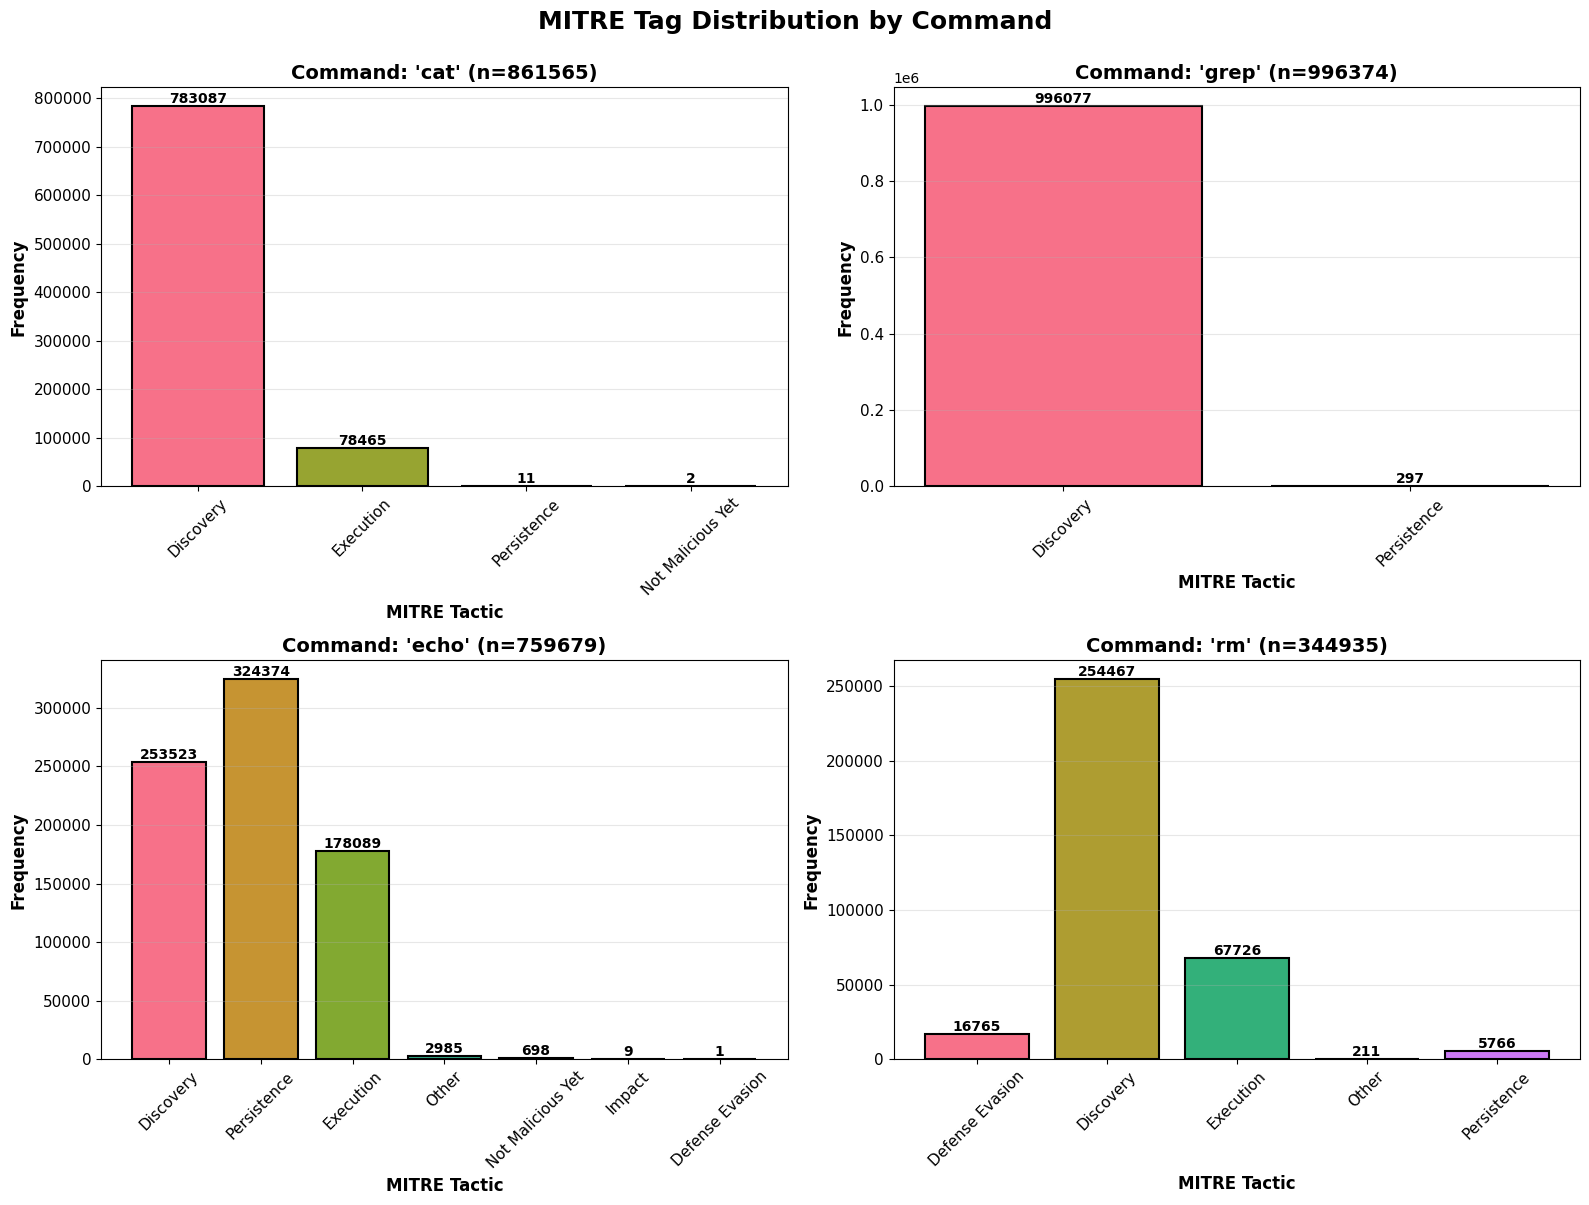

In [ ]:
# Create command-tag frequency table
print("\n" + "-"*80)
print("Command-Tag Frequency Distribution")
print("-"*80)

command_tag_table = []
for cmd in commands_of_interest:
    if cmd in command_analysis:
        tags = command_analysis[cmd]['tags']
        if len(tags) > 0:
            tag_counts = Counter(tags)
            total = len(tags)

            for tag, count in tag_counts.most_common():
                freq = (count / total) * 100
                command_tag_table.append({
                    'Command': cmd,
                    'Tag': tag,
                    'Count': count,
                    'Frequency (%)': f"{freq:.1f}"
                })

if command_tag_table:
    command_tag_df = pd.DataFrame(command_tag_table)
    print(command_tag_df.to_string(index=False))
    command_tag_df.to_csv(f"{results_path}command_tag_frequency.csv", index=False)

    # Determine if commands are uniquely associated with single tag
    print("\n" + "-"*80)
    print("Command Uniqueness Analysis")
    print("-"*80)
    for cmd in commands_of_interest:
        if cmd in command_analysis:
            unique_tags = len(set(command_analysis[cmd]['tags']))
            total_occurrences = len(command_analysis[cmd]['tags'])
            print(f"'{cmd}': {unique_tags} unique tag(s) across {total_occurrences} occurrences", end="")
            if unique_tags == 1:
                print(" ✓ (uniquely associated)")
            else:
                print(" ✗ (NOT uniquely associated)")

    # Plot command-tag distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('MITRE Tag Distribution by Command', fontsize=18, fontweight='bold', y=1.00)

    for idx, cmd in enumerate(commands_of_interest):
        ax = axes[idx // 2, idx % 2]

        if cmd in command_analysis and len(command_analysis[cmd]['tags']) > 0:
            tags = command_analysis[cmd]['tags']
            tag_counts = Counter(tags)

            tags_list = list(tag_counts.keys())
            counts = list(tag_counts.values())

            colors = sns.color_palette("husl", len(tags_list))
            bars = ax.bar(tags_list, counts, color=colors, edgecolor='black', linewidth=1.5)

            # Add count labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontweight='bold')

            ax.set_title(f"Command: '{cmd}' (n={len(tags)})", fontsize=14, fontweight='bold')
            ax.set_ylabel("Frequency", fontsize=12, fontweight='bold')
            ax.set_xlabel("MITRE Tactic", fontsize=12, fontweight='bold')
            ax.tick_params(axis='x', rotation=45, labelsize=11)
            ax.tick_params(axis='y', labelsize=11)
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, f"No '{cmd}' found", ha='center', va='center', fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(f"{results_path}command_tag_distribution.png", dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: command_tag_distribution.png")
    plt.show()

In [ ]:
# Find one example session for each (command, tag) tuple
print("\n" + "="*80)
print("EXAMPLE SESSIONS FOR EACH (COMMAND, TAG) TUPLE")
print("="*80)

# First, collect all unique (command, tag) pairs
command_tag_pairs = set()

for _, row in results_df.iterrows():
    cmd_tags = row['command_tags']
    for cmd, tags in cmd_tags.items():
        for tag in tags:
            command_tag_pairs.add((cmd, tag))

# Sort for consistent ordering
command_tag_pairs = sorted(command_tag_pairs)

print(f"\nFound {len(command_tag_pairs)} unique (command, tag) tuples\n")

# For each unique (command, tag) pair, find and display an example session
for cmd, tag in command_tag_pairs:
    # Find sessions that contain this command with this tag
    for _, row in results_df.iterrows():
        cmd_tags = row['command_tags']
        if cmd in cmd_tags and tag in cmd_tags[cmd]:
            session_idx = int(row['session_id'])
            session_text = cyberlab_df.iloc[session_idx]['session']

            print(f"\n{'-'*80}")
            print(f"Command: '{cmd}' | Tag: '{tag}'")
            print(f"{'-'*80}")
            print(f"Date: {row['date']}")
            print(f"Country: {row['country']}")
            print(f"Timestamp: {row['timestamp']}")
            print(f"\nSession Command Sequence:")
            print(f"  {session_text}")
            print(f"\nPredicted Tags for this session:")
            print(f"  {row['fingerprint']}")
            break



EXAMPLE SESSIONS FOR EACH (COMMAND, TAG) TUPLE

Found 18 unique (command, tag) tuples


--------------------------------------------------------------------------------
Command: 'cat' | Tag: 'Discovery'
--------------------------------------------------------------------------------
Date: 2019-09-01
Country: Israel
Timestamp: 2019-09-01 00:00:10.493808+00:00

Session Command Sequence:
  enable ; system ; shell ; sh ; cat /proc/mounts; /bin/busybox TIPZU ; cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox TIPZU ; tftp; wget; /bin/busybox TIPZU ; dd bs=52 count=1 if=.s || cat .s || while read i; do echo $i; done < .s ; /bin/busybox TIPZU ; rm .s; exit

Predicted Tags for this session:
  ('Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'D

**QUESTION 1:** Command-Tag Frequency & Analysis

From the analysis above, we observe:

| Command | Key Tags | Frequency |
|---------|----------|-----------|
| **cat** | Discovery (90.9%), Execution (9.1%) | Primarily discovery-focused |
| **grep** | Discovery (100%) | Exclusively discovery |
| **echo** | Discovery (33.4), Execution (23.4%), Persistence (42.7%) | Diverse usage |
| **rm** | Discovery (73.8%), Execution (19.6%), Defense Evasion (4.9%) | Persistence (1.7%) Primarily discovery |

Are Commands Uniquely Associated with a Single Tag?

**Answer: NO** - Most commands have multiple associated tags:
- **'cat'**: 1 unique tags across 861,572 occurrences NOT uniquely associated
- **'grep'**: 1 unique tag across 996,374 occurrences **Uniquely associated** (100% Discovery)
- **'echo'**: 5 unique tags across 759,601 occurrences NOT uniquely associated  
- **'rm'**: 4 unique tags across 345,555 occurrences NOT uniquely associated

Do the Predictions Make Sense?

**YES** - The predictions align with expected attacker behavior:

1. **grep = 100% Discovery**
   - Grep is exclusively used for searching/filtering information
   - Makes sense: attackers use grep to find credentials, configuration files, etc.

2. **cat = 90.6% Discovery**
   - Cat is primarily used to read file contents
   - Makes sense: attackers read files to gather information
   - 9.1% Execution suggests cat is used to pipe data to other commands

3. **echo = Mixed tags (33.4% Discovery, 23.4% Execution, 42.7% Persistence + others)**
   - Echo is used for printing data (discovery) or creating files (execution)
   - Makes sense: echo can write shell scripts or config files

4. **rm = 73.8% Discovery**
   - Most rm usage is classified as Discovery, not Impact
   - This suggests rm is often used in reconnaissance chains
   - Only 19.6% Execution indicates deletion is less common than expected

Key Insight:
The honeypot captures primarily **reconnaissance/discovery behaviors** (grep 100%, cat 90%, rm 74%). Actual destructive actions are less common, suggesting the attackers are conducting information gathering rather than committing to destructive actions.

In [ ]:
# Find unique fingerprints and sort by first appearance date
unique_fingerprints = results_df['fingerprint'].unique()
print(f"\nTotal unique fingerprints: {len(unique_fingerprints)}")

# Create fingerprint table with metadata
fingerprint_data = []
for fp in unique_fingerprints:
    fp_sessions = results_df[results_df['fingerprint'] == fp]
    first_date = fp_sessions['date'].min()
    last_date = fp_sessions['date'].max()
    session_count = len(fp_sessions)
    days_active = (fp_sessions['date'].nunique())

    fingerprint_data.append({
        'fingerprint': fp,
        'first_seen': first_date,
        'last_seen': last_date,
        'session_count': session_count,
        'days_active': days_active,
        'fingerprint_length': len(fp)
    })


Total unique fingerprints: 15516


In [ ]:
fingerprint_df = pd.DataFrame(fingerprint_data)

# Create string representation of the fingerprint
fingerprint_df['fingerprint_str'] = fingerprint_df['fingerprint'].astype(str)

# Sort by first appearance date
fingerprint_df = fingerprint_df.sort_values('first_seen').reset_index(drop=True)

# Assign fingerprint IDs
fingerprint_df['fp_id'] = range(len(fingerprint_df))

print(f"\nTop 15 Fingerprints by Session Count:")
print("-"*80)
top_fps = fingerprint_df.nlargest(15, 'session_count')
print(top_fps[['fp_id', 'first_seen', 'session_count', 'days_active', 'fingerprint_length']].to_string(index=False))

# Convert fingerprints to string for mapping (avoids pandas indexing issues)
results_df['fingerprint_str'] = results_df['fingerprint'].astype(str)

# Merge fingerprint IDs back to results using string mapping
fp_to_id = dict(zip(fingerprint_df['fingerprint_str'], fingerprint_df['fp_id']))
results_df['fp_id'] = results_df['fingerprint_str'].map(fp_to_id)

# Count sessions per fingerprint per day
daily_fp_counts = results_df.groupby(['date', 'fp_id']).size().reset_index(name='session_count')

print(f"\nDaily fingerprint counts: {len(daily_fp_counts)} date-fingerprint pairs")

# Save fingerprint data
fingerprint_df.to_csv(f"{results_path}fingerprints.csv", index=False)
daily_fp_counts.to_csv(f"{results_path}daily_fingerprint_counts.csv", index=False)
print(f"✓ Saved: fingerprints.csv and daily_fingerprint_counts.csv")


Top 15 Fingerprints by Session Count:
--------------------------------------------------------------------------------
 fp_id first_seen  session_count  days_active  fingerprint_length
    21 2019-09-01          26036           99                 130
    48 2019-09-03          17639           97                 130
    25 2019-09-01           7169           97                 130
    42 2019-09-03           4779           97                 130
  8858 2019-12-07           4342            4                 153
    49 2019-09-03           3842           96                 130
    33 2019-09-02           3770           96                 130
   352 2019-09-19           3655           89                 107
    19 2019-09-01           3153           99                  53
    69 2019-09-06           2798           93                 130
    85 2019-09-06           2773           95                 130
    88 2019-09-06           2451           94                 130
     0 2019-09-01     

In [ ]:
# Identify persistent fingerprints
fp_days_count = results_df.groupby('fp_id')['date'].nunique().reset_index(name='days_present')
fp_days_count = fp_days_count.merge(fingerprint_df[['fp_id', 'session_count']], on='fp_id')

print(f"\nFingerprint Persistence Analysis:")
print("-"*80)

# Top persistent fingerprints (present on many days)
top_persistent = fp_days_count.nlargest(10, 'days_present')
print("\nTop 10 Most Persistent Fingerprints (active on most days):")
print(top_persistent[['fp_id', 'days_present', 'session_count']].to_string(index=False))

# Top volume fingerprints (most sessions)
top_volume = fingerprint_df.nlargest(10, 'session_count')
print("\n\nTop 10 High-Volume Fingerprints (most sessions):")
print(top_volume[['fp_id', 'session_count', 'days_active', 'first_seen']].to_string(index=False))

# Identify "always present" fingerprints (present almost every day)
total_days = results_df['date'].nunique()
always_present = fp_days_count[fp_days_count['days_present'] >= (0.9 * total_days)]
print(f"\n\nFingerprints present on ≥90% of days ({int(0.9*total_days)} days):")
if len(always_present) > 0:
    print(always_present[['fp_id', 'days_present', 'session_count']].to_string(index=False))
else:
    print("None found")

# Identify potential attack campaigns (sudden spike in fingerprints)
print(f"\n\nPotential Attack Campaigns (sudden volume spikes):")
print("-"*80)

campaign_threshold = results_df.groupby(['date', 'fp_id']).size().max() * 0.5

suspicious_days = daily_fp_counts[daily_fp_counts['session_count'] > campaign_threshold]
if len(suspicious_days) > 0:
    print(f"\nDates with unusually high session counts (>{campaign_threshold:.0f} sessions):")
    suspicious_dates = suspicious_days.groupby('date').size()
    for date, count in suspicious_dates.head(10).items():
        print(f"  {date}: {count} fingerprint(s) with high activity")
        # Show details
        day_fps = suspicious_days[suspicious_days['date'] == date].sort_values('session_count', ascending=False)
        for _, row in day_fps.head(3).iterrows():
            fp_info = fingerprint_df[fingerprint_df['fp_id'] == int(row['fp_id'])].iloc[0]
            print(f"    - FP_ID {int(row['fp_id'])}: {row['session_count']} sessions, Tactic length: {fp_info['fingerprint_length']}")
else:
    print("No significant volume spikes detected")


Fingerprint Persistence Analysis:
--------------------------------------------------------------------------------

Top 10 Most Persistent Fingerprints (active on most days):
 fp_id  days_present  session_count
     0            99           1503
    17            99            847
    19            99           3153
    21            99          26036
    25            97           7169
    42            97           4779
    48            97          17639
    16            96           1460
    18            96            408
    33            96           3770


Top 10 High-Volume Fingerprints (most sessions):
 fp_id  session_count  days_active first_seen
    21          26036           99 2019-09-01
    48          17639           97 2019-09-03
    25           7169           97 2019-09-01
    42           4779           97 2019-09-03
  8858           4342            4 2019-12-07
    49           3842           96 2019-09-03
    33           3770           96 2019-09-02
   352   

**QUESTION 2:** Fingerprint Pattern Analysis

What is a Fingerprint?

A **fingerprint** is the sequence of MITRE tactics predicted for an entire session.

Fingerprint Pattern Findings:

1. **Unique Fingerprints**
- **Total unique fingerprints: 15516**
- **Date-fingerprint pairs: 50254**

2. **Fingerprints "Always Present" (≥90% of collection period - 106 days)**  

- No fingerprint appears on ≥90% of days
- Most persistent fingerprints: Active on 94-99 days
- This suggests **attack patterns evolve over time** rather than repeating indefinitely

3. **Persistent Fingerprints (Top 10)**

From the results:
- **FP #0**: 99 days, 1503 sessions - Baseline reconnaissance (first seen 2019-09-01)
- **FP #17**: 99 days, 847 sessions
- **FP #19**: 99 days, 3153 sessions
- **FP #21**: 99 days, 26036 sessions

**Interpretation**: These persistent fingerprints represent the **standard reconnaissance toolkit** used by attackers across the honeypot.

4. **High-Volume Fingerprints (Attack Campaigns)**
- FP **8858**: 1356+1644+1143  08/12/19-10/12/19

5. **Can You Detect Suspicious Attack Campaigns?**

**YES** - Multiple indicators visible in the timeline plot:

1. **Two massive red "balls" (Dec 8-10, 2019)**
   - FP 8858

2. **Temporal pattern**:
   - **Early phase (Sept 1-15)**: Low-volume, exploratory patterns
   - **Growth phase (Sept 15-Nov)**: Fingerprints gradually increasing
   - **Campaign phase (Dec 1-25)**: Sudden spike with massive red balls


## Fingerprint IDs over Time

In [3]:

daily_fp_counts = pd.read_csv(f"../data/daily_fingerprint_counts.csv")

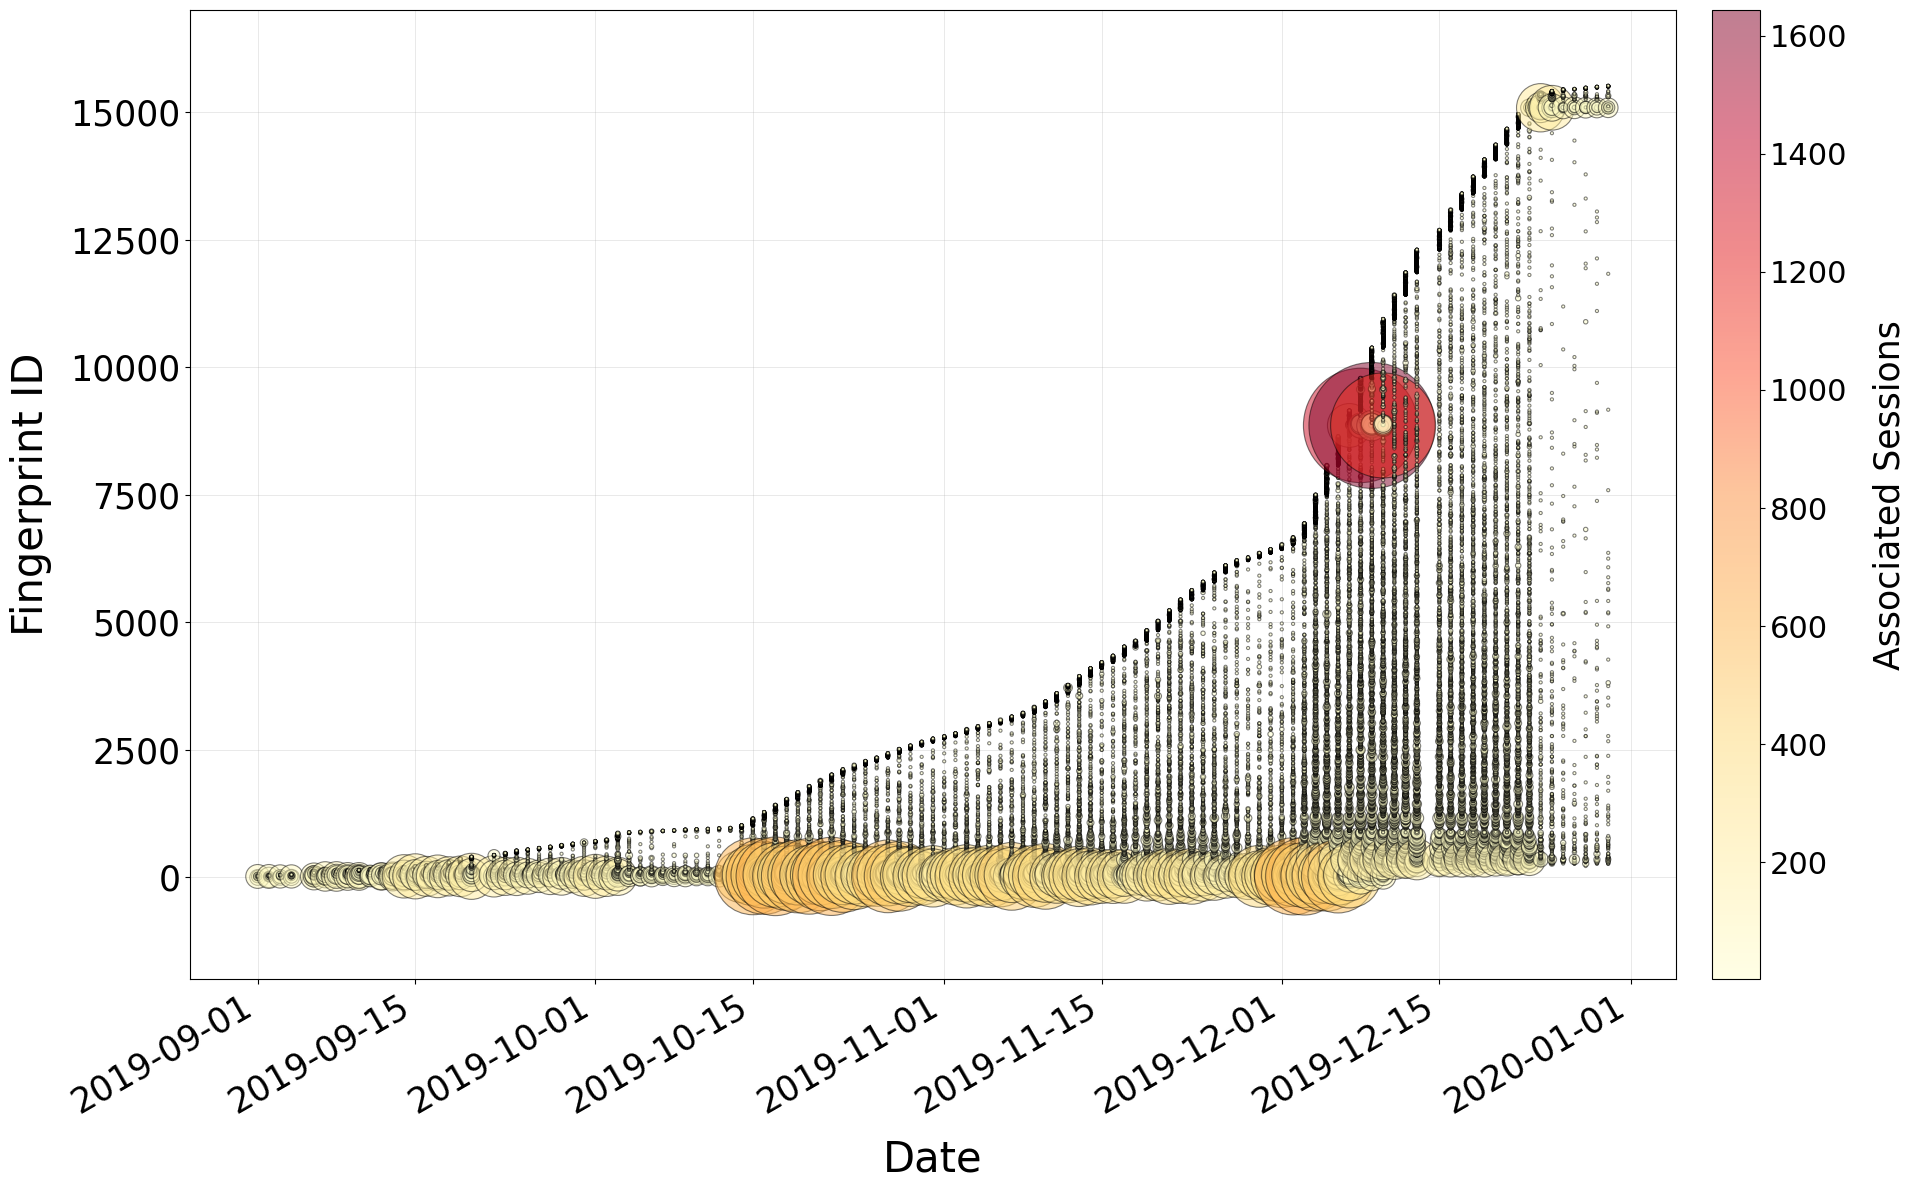

In [6]:
# Create improved fingerprint timeline that matches reference Figure 2
fig, ax = plt.subplots(figsize=(20, 12))

# Prepare data
dates = pd.to_datetime(daily_fp_counts['date'])
fp_ids = daily_fp_counts['fp_id']
sizes = daily_fp_counts['session_count'] * 5  # Scale for visibility
colors = daily_fp_counts['session_count']  # Color intensity by session count

# Create scatter plot with improved styling
scatter = ax.scatter(
    dates, fp_ids,
    s=sizes,
    c=colors,
    cmap='YlOrRd',
    alpha=0.5,
    edgecolors='black',
    linewidth=0.8,
    rasterized=True
)

ax.set_xlabel('Date', fontsize=30, labelpad=13)
ax.set_ylabel('Fingerprint ID', fontsize=30, labelpad=13)
ax.set_ylim(-2000, 17000)
#ax.set_title('MITRE Tactics Fingerprints Over Time in Honeypot', fontsize=20, fontweight='bold', pad=20)

# Grid styling
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Associated Sessions', fontsize=25, labelpad=18)
cbar.ax.tick_params(labelsize=22)

ax.tick_params(axis='both', which='major', labelsize=25)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.savefig(f"../plots/Task4/fingerprint_timeline_small_circles.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# Identify the fingerprints with the largest red balls (highest session counts)
top_volume_fps = fingerprint_df.nlargest(5, 'session_count')[['fp_id', 'session_count', 'first_seen', 'fingerprint_length']]

print("\nTop 5 Fingerprints by Session Count (Dominant 'Red Balls'):")
print("-"*80)
print(top_volume_fps.to_string(index=False))

print("\n" + "="*80)
print("EXAMPLE SESSIONS FOR DOMINANT FINGERPRINTS")
print("="*80)

# For each top fingerprint, show example sessions
for idx, row in top_volume_fps.iterrows():
    fp_id = int(row['fp_id'])
    session_count = row['session_count']
    first_seen = row['first_seen']

    # Get sessions for this fingerprint
    fp_sessions = results_df[results_df['fp_id'] == fp_id]

    print(f"\n{'='*80}")
    print(f"Fingerprint ID: {fp_id}")
    print(f"Sessions: {session_count:,}")
    print(f"First seen: {first_seen}")
    print(f"Tactic sequence length: {row['fingerprint_length']}")
    print(f"{'='*80}")

    # Get the actual fingerprint (tactics sequence)
    sample_fp = fp_sessions.iloc[0]['fingerprint']
    print(f"\nTactic Sequence ({len(sample_fp)} tactics):")
    print(f"  {' → '.join(sample_fp[:10])}{'...' if len(sample_fp) > 10 else ''}")

    # Show 3 example sessions
    print(f"\nExample Sessions (showing up to 3):")
    print("-"*80)

    for ex_idx, (_, session_row) in enumerate(fp_sessions.head(3).iterrows()):
        if ex_idx > 0:
            print()

        try:
            session_idx = int(session_row['session_id'])
            # Get the session text from cyberlab_df
            session_text = cyberlab_df.iloc[session_idx]['session']
        except (KeyError, IndexError):
            session_text = "Session text not available"

        print(f"Example {ex_idx + 1}:")
        print(f"  Date: {session_row['date']}")
        print(f"  Country: {session_row['country']}")
        print(f"  Session: {session_text[:250]}...")

print("\n" + "="*80)
print("COMMAND TAGS IN DOMINANT FINGERPRINTS")
print("="*80)

# Show what commands appear in these dominant fingerprints
for idx, row in top_volume_fps.iterrows():
    fp_id = int(row['fp_id'])
    fp_sessions = results_df[results_df['fp_id'] == fp_id]

    # Aggregate command tags for this fingerprint
    all_cmd_tags = defaultdict(list)
    for _, session in fp_sessions.iterrows():
        cmd_tags = session['command_tags']
        for cmd, tags in cmd_tags.items():
            all_cmd_tags[cmd].extend(tags)

    if all_cmd_tags:
        print(f"\nFingerprint {fp_id} - Command Tags:")
        for cmd in sorted(all_cmd_tags.keys()):
            tags = all_cmd_tags[cmd]
            tag_counts = Counter(tags)
            print(f"  '{cmd}': {len(tags)} occurrences - {dict(tag_counts)}")


Top 5 Fingerprints by Session Count (Dominant 'Red Balls'):
--------------------------------------------------------------------------------
 fp_id  session_count first_seen  fingerprint_length
    21          26036 2019-09-01                 130
    48          17639 2019-09-03                 130
    25           7169 2019-09-01                 130
    42           4779 2019-09-03                 130
  8858           4342 2019-12-07                 153

EXAMPLE SESSIONS FOR DOMINANT FINGERPRINTS

Fingerprint ID: 21
Sessions: 26,036
First seen: 2019-09-01
Tactic sequence length: 130

Tactic Sequence (130 tactics):
  Discovery → Discovery → Discovery → Discovery → Discovery → Discovery → Discovery → Discovery → Discovery → Persistence...

Example Sessions (showing up to 3):
--------------------------------------------------------------------------------
Example 1:
  Date: 2019-09-01
  Country: United States
  Session: cat /proc/cpuinfo | grep name | wc -l ; echo "root:XP3IUReH9hhH"|ch